# Predict anchor from prior frequency
Let's move away from "time" as a variable and try to predict anchor based on prior frequency:

- Predict $P(\text{anchor}_{t} \: | \: f_{t-1})$

We have to check that the anchor detection code is working right before applying it to the data.

In [2]:
import pandas as pd
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)

In [3]:
import pickle
geo_dict_US = pickle.load(open('/hg190/corpora/GeoNames/allCountriesSimplified_lookup_US.pickle', 'rb'))
print('%d entries'%(len(geo_dict_full)))

12066434 entries


In [4]:
%%timeit
test_name = 'houston'
geo_data_i = geo_dict_full[test_name]

59.6 ns ± 0.0485 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
from unidecode import unidecode
import re
from data_helpers import normalize_str
geonames_data.fillna('', inplace=True)
# PAREN_MATCHER = re.compile('[\(\)]+|\(.+|\)|\[.*|\]')
# def full_normalize_str(x):
#     x = normalize_str(x)
#     x = PAREN_MATCHER.sub('', x)
#     return x
# def build_regex(x):
#     try:
#         x_re = re.compile(full_normalize_str('|'.join([x.loc['name']]+x.loc['alternate_names'].split(','))))
#     except Exception as e:
#         print('error %s'%(e))
#         print('name=%s'%(x.loc['name']))
#         x_re = re.compile(full_normalize_str(x.loc['name']))
#     return x_re
def build_name_regex(x):
    try:
        x_regex = re.compile('|'.join(['^%s$'%(y.lower()) for y in set([x.loc['name']]+str(x.loc['alternate_names']).split(',')) - set([''])]))
    except Exception as e:
        x_regex = ''
    return x_regex
geonames_data = geonames_data.assign(**{'name_regex':geonames_data.apply(lambda x: build_name_regex(x), axis=1)})
# # drop null names
geonames_data = geonames_data[geonames_data.loc[:, 'name_regex'] != '']

In [6]:
%%timeit
test_name = 'houston'
geo_data_i = geonames_data[geonames_data.loc[:, 'name_regex'].apply(lambda x: x.search(test_name) is not None)]

9.37 s ± 822 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
# sanity check anchor detection
import pandas as pd
import pickle
from importlib import reload
import collect_validate_NEs_in_tweets
reload(collect_validate_NEs_in_tweets)
from collect_validate_NEs_in_tweets import find_NE_anchors
geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))
test_data_1 = pd.DataFrame(
    [
        [1234, 'test_data', 'LOCATION', 'san juan'],
        [1234, 'test_data', 'LOCATION', 'puerto rico'],
    ], 
    columns=['id', 'data_name_fixed', 'NE_type', 'NE_fixed']
)
test_data_2 = pd.DataFrame(
    [
        [1234, 'test_data', 'LOCATION', 'houston'],
        [1234, 'test_data', 'LOCATION', 'austin'],
    ], 
    columns=['id', 'data_name_fixed', 'NE_type', 'NE_fixed']
)
test_data_3 = pd.DataFrame(
    [
        [1234, 'test_data', 'LOCATION', 'houston'],
        [1234, 'test_data', 'LOCATION', 'texas'],
    ], 
    columns=['id', 'data_name_fixed', 'NE_type', 'NE_fixed']
)
test_data = [test_data_1, test_data_2, test_data_3]
for test_data_i in test_data:
    anchor_data = find_NE_anchors(test_data_i, geo_dict, verbose=True)
    print('***final anchor data***')
    print(anchor_data)

generated data_loc:
     id data_name_fixed   NE_type     NE_fixed  max_population  max_alternate_name_count
0  1234       test_data  LOCATION     san juan          431285                        58
1  1234       test_data  LOCATION  puerto rico         3916632                        90
processing data:
     id data_name_fixed   NE_type     NE_fixed  max_population  max_alternate_name_count
0  1234       test_data  LOCATION     san juan          431285                        58
1  1234       test_data  LOCATION  puerto rico         3916632                        90
updated data:
     id data_name_fixed   NE_type     NE_fixed  max_population  max_alternate_name_count  max_population_anchor  max_population_diff
0  1234       test_data  LOCATION     san juan          431285                        58                   True              3485347
1  1234       test_data  LOCATION  puerto rico         3916632                        90                  False                    0
updated data:
  

### Process frequency data
Let's convert the raw text into frequency counts and subdivide by time period.

In [24]:
## collect text, status files
import pandas as pd
import os
import re
import dateutil
import gzip
data_dir = '../../data/mined_tweets/'
txt_file_matcher = re.compile('_txt\.txt$')
status_file_matcher = re.compile('_status\.gz$')
tag_file_matcher = re.compile('(archive|stream|historical)_[a-z]+_txt_tags\.gz$')
tag_files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if tag_file_matcher.search(x) is not None]
combined_txt_data = []
data_name_matcher = re.compile('[a-z]+(?=_txt_tags\.gz)')
for f in tag_files:
    print('processing file %s'%(os.path.basename(f)))
    f_status = f.replace('_txt_tags.gz', '_status.gz')
    f_txt = f.replace('_txt_tags.gz', '_txt.txt')
    f_data = pd.read_csv(f_status, sep='\t', index_col=False, compression='gzip', header=None, converters={2:dateutil.parser.parse})
    f_data.columns = ['id', 'username', 'date', 'retweets', 'likes', 'lang']
    f_data = f_data.assign(**{'id' : f_data.loc[:, 'id'].astype(int)})
    f_txt = [l.strip() for l in open(f_txt, 'r')]
    f_data = f_data.assign(**{'txt':f_txt})
    # label with data name
    f_name = data_name_matcher.search(os.path.basename(f)).group(0)
    f_data = f_data.assign(**{'data_name':f_name})
    f_tag_data = pd.DataFrame([l.decode('utf-8').strip().split('\t') for l in gzip.open(f, 'rb')], columns=['id', 'tags'])
    # convert tags to list
    f_tag_data = f_tag_data.assign(**{'tags' : f_tag_data.loc[:, 'tags'].apply(lambda x: [y.split('/') for y in x.split(' ')])})
    ## fix tag triples??
    f_tag_data = f_tag_data.assign(**{'tags' : f_tag_data.loc[:, 'tags'].apply(lambda x: [[' '.join(y[:-1]), y[-1]] for y in x])})
    f_tag_data = f_tag_data.assign(**{'id':f_tag_data.loc[:, 'id'].astype(int)})
    f_data = pd.merge(f_data, f_tag_data, on='id')
#     print('%d/%d data'%(len(f_txt), f_data.shape[0]))
#     display(f_data.head())
    combined_txt_data.append(f_data)
combined_txt_data = pd.concat(combined_txt_data, axis=0)
print('%d combined statuses'%(combined_txt_data.shape[0]))

processing file stream_maria_txt_tags.gz
processing file archive_maria_txt_tags.gz
processing file archive_florence_txt_tags.gz
processing file archive_michael_txt_tags.gz
processing file stream_irma_txt_tags.gz
processing file stream_harvey_txt_tags.gz
processing file archive_harvey_txt_tags.gz
processing file archive_irma_txt_tags.gz
processing file historical_maria_txt_tags.gz
processing file historical_harvey_txt_tags.gz
processing file historical_irma_txt_tags.gz
processing file historical_florence_txt_tags.gz
processing file historical_michael_txt_tags.gz
4087424 combined statuses


In [25]:
## remove duplicates
print('%d statuses before deduplication'%(combined_txt_data.shape[0]))
combined_txt_data.drop_duplicates(['id', 'data_name'], inplace=True)
print('%d statuses after deduplication'%(combined_txt_data.shape[0]))

4087424 statuses before deduplication
2265884 statuses after deduplication


Compute days as the normalized date.

In [79]:
from datetime import datetime
def compute_days(data):
    data_time = data.assign(**{'date_day' : data.loc[:, 'date'].apply(lambda x: datetime(day=x.day, month=x.month, year=x.year))})
#     data_time = pd.concat([data_i.assign(**{'days_since_start' : data_i.apply(lambda x: (data_i.loc[:, 'date_day'].max() - x.loc['date_day']).days, axis=1)}) for data_name_i, data_i in data_time.groupby('data_name')], axis=0)
    return data_time
## convert date to relative day
combined_txt_data_time = compute_days(combined_txt_data)

Combine all adjacent NEs in tagged data:

"I/O am/O in/O Puerto/LOC Rico/LOC" => "I am in Puerto_Rico"

In [80]:
## combine adjacent NEs
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_NEs_from_tags
def convert_tags_to_txt(tags):
    tag_list = extract_NEs_from_tags(tags, keep_all_tokens=True)
    return tag_list
combined_txt_data_time = combined_txt_data_time.assign(**{'tagged_txt' : combined_txt_data_time.loc[:, 'tags'].apply(lambda x: convert_tags_to_txt(x))})

In [41]:
from functools import reduce
tag_type_counts = pd.Series([y[1] for x in combined_txt_data_time.loc[:, 'tagged_txt'].values for y in x]).value_counts()
print(tag_type_counts)

O                    41718550
geo                    571746
person                 363191
other                  144195
company                 66243
band                    55173
movie                   53983
O"                      43069
facility                36478
ORGANIZATION            27114
product                 23995
NUMBER                  21880
tvshow                  21635
CAUSE_OF_DEATH          20623
PERSON                  16759
sportsteam              14273
LOCATION                 9682
COUNTRY                  8812
MISC                     6943
CITY                     6810
NONE                     6775
DATE                     4779
TITLE                    4345
STATE_OR_PROVINCE        3944
PERCENT                   760
NATIONALITY               710
MONEY                     669
IDEOLOGY                  230
CRIMINAL_CHARGE           113
ORGANIZATION"              98
                       ...   
dejaría                     1
sea                         1
@jaarreaza

In [218]:
## group by day, compute token frequency
from sklearn.feature_extraction.text import CountVectorizer
import data_helpers
reload(data_helpers)
from data_helpers import clean_tweet_txt
from functools import reduce
from stop_words import get_stop_words
from unidecode import unidecode

def norm_entity_type(txt, entity_type_matchers):
    """
    Normalize entity type if text matches.
    """
    for entity_type_matcher, entity_marker in entity_type_matchers:
        if(entity_type_matcher.search(txt) is not None):
            txt = entity_type_matcher.sub(entity_marker, txt)
    return txt

QUOTE_MATCHER = re.compile('\'|"|”|“')
HANGING_UNDERSCORE_MATCHER = re.compile('^_|_$')
PUNCT_MATCHER = re.compile('_*[!,\.;:]_*')
GENERIC_MATCHER = re.compile('.*(#+|#\s*hash|\s*<\s*url\s*>|\s*<\s*num\s*>).*')
def clean_strip_txt(x):
    x = x.strip()
    x = x.replace(' ', '_')
    x = clean_tweet_txt(x)
    x = unidecode(x)
    # strip quotes!!
    x = QUOTE_MATCHER.sub('', x)
    x = PUNCT_MATCHER.sub('', x)
    x = GENERIC_MATCHER.sub('', x)
    x = HANGING_UNDERSCORE_MATCHER.sub('', x)
    return x

def compute_time_frequency(data, time_var='date_day', stopword_langs=['en', 'es']):
    """
    Compute frequency over time of text tokens.
    
    :param data: pandas.DataFrame with raw text, tags, time
    :returns freq:: pandas.DataFrame with normalized type frequency (row) per date (col)
    """
    # group tag data by date
    # compute raw NE frequencies at each t
    # normalize for token count at t
    freq = []
    LOC_TYPES = set(['COUNTRY', 'LOCATION', 'CITY', 'geo'])
    LOC_TYPE_MATCHER = re.compile('|'.join(['_%s$'%(x) for x in LOC_TYPES]))
    LOC_MARKER = '_LOC'
    ENTITY_TYPE_MARKERS = [[LOC_TYPE_MATCHER, LOC_MARKER]]
    min_df = 0.00001
    max_df = 0.75
    min_df_per_time = 10
    stopwords = set(reduce(lambda x,y: x|y, [set(get_stop_words(x)) for x in stopword_langs]))
    TKNZR = lambda x: x.split(' ')
    
    ## convert all text to DTM, then group by time
    txt = data.loc[:, 'tagged_txt']
    txt_tokens_tags = txt.apply(lambda x: [[clean_strip_txt(y[0].replace(' ', '_')), y[1]] for y in x])
    # remove blanks
    txt_tokens_tags = txt_tokens_tags.apply(lambda x: [y for y in x if y[0] != ''])
    txt_tokens = txt_tokens_tags.apply(lambda x: ' '.join(['%s_%s'%(y[0], y[1]) if y[1] != 'O' else y[0] for y in x]))
    # normalize entity types to same marker
    # ex. COUNTRY/LOCATION/CITY/GEO => LOC
    txt_tokens = txt_tokens.apply(lambda x: ' '.join([norm_entity_type(y, ENTITY_TYPE_MARKERS) for y in x.split(' ')]))
    cv = CountVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1,1), stop_words=stopwords, tokenizer=TKNZR)
    dtm = cv.fit_transform(txt_tokens)
    cv_vocab = sorted(cv.vocabulary_.keys(), key=lambda x: cv.vocabulary_[x])
    for time_i in data.loc[:, time_var].unique():
        time_i_idx = np.where(data.loc[:, time_var] == time_i)[0]
        dtm_i = dtm[time_i_idx, :]
        dtm_i = pd.Series(np.squeeze(np.asarray(dtm_i.sum(axis=0))), index=cv_vocab)
        dtm_i = dtm_i / dtm_i.sum()
        freq.append([time_i, dtm_i])
    ## group bytime, then convert time text to DTM
#     for time_i, data_i in data.groupby(time_var):
#         txt_i = data_i.loc[:, 'tagged_txt']
#         txt_tokens_tags_i = txt_i.apply(lambda x: [[clean_strip_txt(y[0].replace(' ', '_')), y[1]] for y in x])
#         # remove blanks
#         txt_tokens_tags_i = txt_tokens_tags_i.apply(lambda x: [y for y in x if y[0] != ''])
#         txt_tokens_i = txt_tokens_tags_i.apply(lambda x: ' '.join(['%s_%s'%(y[0], y[1]) if y[1] != 'O' else y[0] for y in x]))
#         # normalize entity types to same marker
#         # ex. COUNTRY/LOCATION/CITY/GEO => LOC
#         txt_tokens_i = txt_tokens_i.apply(lambda x: ' '.join([norm_entity_type(y, ENTITY_TYPE_MARKERS) for y in x.split(' ')]))
#         if(len(txt_tokens_i) >= min_df_per_time):
#             cv = CountVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1,1), stop_words=stopwords, tokenizer=TKNZR)
#             dtm = cv.fit_transform(txt_tokens_i)
#             dtm = pd.Series(np.squeeze(np.asarray(dtm.sum(axis=0))), index=sorted(cv.vocabulary_.keys(), key=lambda x: cv.vocabulary_[x]))
#             # normalize
#             dtm = dtm / dtm.sum()
#             freq.append([time_i, dtm])
    freq_time, freq_counts = list(zip(*freq))
    freq_data = pd.concat(freq_counts, axis=1).transpose()
    freq_data = freq_data.assign(**{'TIME' : freq_time})
    freq_data.fillna(0., inplace=True)
    return freq_data
combined_freq = []
for data_name_i, data_i in combined_txt_data_time.groupby('data_name'):
    print('processing data %s'%(data_name_i))
    freq_data_i = compute_time_frequency(data_i)
#     display(freq_data_i.head())
#     freq_data_i_sum = freq_data_i.drop('TIME', axis=1, inplace=False).sum(axis=0).sort_values(inplace=False, ascending=False)
#     display(freq_data_i_sum.loc[[x for x in freq_data_i_sum.index if x.endswith('_geo')]])
    freq_data_i = freq_data_i.assign(**{'DATA_NAME' : data_name_i})
    combined_freq.append(freq_data_i)
combined_freq = pd.concat(combined_freq, axis=0)
combined_freq.fillna(0, inplace=True)

processing data florence
processing data harvey
processing data irma
processing data maria
processing data michael


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [219]:
# combined_freq.fillna(0, inplace=True)
display(combined_freq.head())
print(combined_freq.columns)

,,$,$_<num><num>_money,$_<num>_million_money,$_<num>_money,%,&,(,(*<num>,(c),...,zurichna,zurichnanews,zwy_band,zz,zzward,zzzzzzzzzzz,{,|,},~
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004545,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['', '$', '$_<num><num>_money', '$_<num>_million_money', '$_<num>_money',
       '%', '&', '(', '(*<num>', '(c)',
       ...
       'zurichna', 'zurichnanews', 'zwy_band', 'zz', 'zzward', 'zzzzzzzzzzz',
       '{', '|', '}', '~'],
      dtype='object', length=80079)


In [220]:
## let's look at the top frequency words 
top_k = 20
print('%d/%d LOC cols'%(len([x for x in combined_freq.columns if x.endswith('_loc')]), combined_freq.shape[1]))
for data_name_i, data_i in combined_freq.groupby('DATA_NAME'):
    print('testing data=%s'%(data_name_i))
    data_i_freq = data_i.drop(['TIME', 'DATA_NAME'], axis=1, inplace=False)
    # overall freq
    print(data_i_freq.mean(axis=0).sort_values(inplace=False, ascending=False).iloc[:top_k])
    # LOC word freq
    data_i_freq_loc = data_i_freq.loc[:, [x for x in data_i_freq.columns if x.endswith('_loc')]]
    print(data_i_freq_loc.mean(axis=0).sort_values(inplace=False, ascending=False).iloc[:top_k])

4668/80079 LOC cols
testing data=florence
<num>        0.081728
@user        0.056655
<            0.043956
url          0.043870
>            0.043168
rt           0.041440
hurricane    0.010800
s            0.009416
-            0.009382
storm        0.008099
tropical     0.007200
now          0.006395
(            0.005226
will         0.004933
just         0.004727
)            0.004285
see          0.003945
forecast     0.003917
latest       0.003830
&            0.003610
dtype: float64
north_carolina_loc                   0.002165
florence_loc                         0.001892
nc_loc                               0.001752
south_carolina_loc                   0.001136
atlantic_loc                         0.000858
sc_loc                               0.000813
atlantic_ocean_loc                   0.000651
cabo_verde_loc                       0.000641
wilmington_loc                       0.000526
new_bern_loc                         0.000422
carolina_loc                         0.0003

Baseline: how readily can we predict $f_{t}$ with $f_{t-1}$? We'll use a basic ARIMA model for the LOC data.

1. Find optimal order by computing BIC for all AR/MA combos for top-$k$ frequency time series.
2. Fit order to all time series.

In [178]:
from statsmodels.tsa.stattools import arma_order_select_ic
max_ar = 4
max_ma = 2
top_k_series = 100
data_ar_ma = []
model_scores_total = 0.
for data_name_i, data_i in combined_freq.groupby('DATA_NAME'):
    print('data=%s'%(data_name_i))
    data_i.sort_values('TIME', inplace=True, ascending=True)
    data_i_freq_loc = data_i.loc[:, [x for x in data_i.columns if x.endswith('_loc')]]
    # restrict to nonzero time series
#     data_i_freq_loc = data_i_freq_loc[(data_i_freq_loc.sum(axis=0)>0.).all(1)]
    data_i_freq_sums = data_i_freq_loc.sum(axis=0)
    nonzero_cols_i = data_i_freq_sums[data_i_freq_sums > 0.].sort_values(inplace=False, ascending=False).index.tolist()
    data_i_freq_loc = data_i_freq_loc.loc[:, nonzero_cols_i]
    print('testing %d/%d time series'%(top_k_series, len(data_i_freq_loc.columns)))
    data_i_freq_loc_k = data_i_freq_loc.loc[:, nonzero_cols_i[:top_k]]
    model_scores_i = 0.
    for c in data_i_freq_loc_k.columns:
        y = data_i_freq_loc_k.loc[:, c]
        # diff to remove trend
        y_diff = y.diff(1).iloc[1:]
        y_res = arma_order_select_ic(y, max_ar=max_ar, max_ma=max_ma, ic=['bic'], trend='nc')
        scores_c = y_res['bic']
        scores_c.fillna(scores_c.max().max(), inplace=True)
        if(np.all(model_scores_i == 0.)):
            model_scores_i = scores_c
        else:
            model_scores_i += scores_c
    # keep track of total scores
    if(np.all(model_scores_total == 0.)):
        model_scores_total = model_scores_i
    else:
        model_scores_total += model_scores_i
    # find AR/MA order with minimal score
    ar_i, ma_i = [x[0] for x in np.where(model_scores_i==model_scores_i.min().min())]
    print('ar=%d, ma=%d'%(ar_i, ma_i))
    data_ar_ma.append([data_name_i, ar_i, ma_i])
data_ar_ma = pd.DataFrame(data_ar_ma, columns=['data_name', 'ar', 'ma'])

data=florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


testing 100/2188 time series


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid v

ar=1, ma=0
data=harvey


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


testing 100/7101 time series


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian f

ar=1, ma=0
data=irma


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


testing 100/9678 time series


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsm

ar=1, ma=0
data=maria


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


testing 100/3898 time series


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid v

ar=1, ma=1
data=michael


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


testing 100/1985 time series


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid v

ar=1, ma=0


In [278]:
display(data_ar_ma)
display(model_scores_total)

,data_name,ar,ma
0,florence,1,0
1,harvey,1,0
2,irma,1,0
3,maria,1,1
4,michael,1,0


,0,1,2
0,-36288.747397,-37254.727476,-37519.815002
1,-37946.840466,-37834.664532,-37674.043123
2,-37808.823573,-37385.968988,-37196.258744
3,-37591.426253,-37401.569924,-37067.554073
4,-37405.955920,-37098.886796,-36827.673810


Great! We see that frequency changes are weakly autoregressive.

### Load anchor data

In [225]:
import dateutil
combined_tag_data_anchors = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
display(combined_tag_data_anchors.head())
print('%d/%d unique tweets'%(combined_tag_data_anchors.loc[:, 'id'].nunique(), combined_tag_data_anchors.shape[0]))
print('%d/%d samples with valid LOC and pop anchor'%(combined_tag_data_anchors[(combined_tag_data_anchors.loc[:, 'max_population_anchor']) & (combined_tag_data_anchors.loc[:, 'valid_loc'])].shape[0], combined_tag_data_anchors.shape[0]))
print('%d/%d samples with valid LOC and names anchor'%(combined_tag_data_anchors[(combined_tag_data_anchors.loc[:, 'max_alternate_name_count_anchor']) & (combined_tag_data_anchors.loc[:, 'valid_loc'])].shape[0], combined_tag_data_anchors.shape[0]))
display(combined_tag_data_anchors[(combined_tag_data_anchors.loc[:, 'max_population_anchor']) & (combined_tag_data_anchors.loc[:, 'valid_loc'])].loc[:, ['NE', 'txt']].head().values)

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,NE_fixed,has_descriptor,NE_fixed_clean,max_population,max_alternate_name_count,max_population_anchor,max_population_diff,max_alternate_name_count_anchor,max_alternate_name_count_diff
0,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43+00:00,en,Leeward_Islands,LOCATION,True,False,leeward_islands,False,leeward islands,0.0,4.0,True,17671452.0,True,72.0
1,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43+00:00,en,Florida,LOCATION,True,False,florida,False,florida,17671452.0,76.0,False,0.0,False,0.0
2,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25+00:00,en,Martinique,LOCATION,True,False,martinique,False,martinique,0.0,0.0,True,285653.0,True,106.0
3,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25+00:00,en,Barbados,LOCATION,True,False,barbados,False,barbados,285653.0,106.0,False,0.0,False,0.0
4,898357862111612928,RT @NWSKeyWest: Tropical Storm #Harvey is movi...,harvey,coty_sandangel4,2017-08-18 01:36:19+00:00,en,Windward_islands,LOCATION,True,False,windward_islands,False,windward islands,0.0,0.0,False,0.0,False,0.0


409445/503653 unique tweets
39267/503653 samples with valid LOC and pop anchor
39183/503653 samples with valid LOC and names anchor


array([['cannon',
        '#Harvey a lose cannon? Where will it hit? Texas? Louisiana? Alabama? Florida? US gulf states better sit up and start worrying <URL>'],
       ['San_Antonio',
        'Looking at @weatherbell #ECMWF rain, 10 to 20 inches lower Brazos, Colorado and San Antonio river basins in Texas w/ #Harvey would be crazy.'],
       ['Galveston',
        'Today looks like a great day to cool off at the beach in Galveston, TX. This weekend could get dicey. #txwx #Harvey <URL>'],
       ['Houston',
        '#hurricaneharvey #providers #providersafety Providers potential hurricane to hit Texas coast thurs/fri. Possible Houston hit.'],
       ['Riverwalk',
        '12Z EURO has #Harvey visting the Riverwalk in San Antonio & #92L developing (finally) E of FL by D5. Lots to watch. #onemodelrun <URL>']],
      dtype=object)

These mostly seem legit! Later we may have to impose a bound on what counts as "anchor" ex. only include anchors with population difference of at least 10x.

TODO: plot anchor distribution over time, same as KDE plots for descriptors.

Now let's join the frequency data with the tagged/anchored data to do proper prediction.

We want the joined data in the following format:

ID | text | valid_loc_NE | date_day | data_name | freq_date_day-1 | freq_date_day-2 | etc.

In [226]:
## convert date -> day
from datetime import datetime
def compute_days(data):
    data_time = data.assign(**{'date_day' : data.loc[:, 'date'].apply(lambda x: datetime(day=x.day, month=x.month, year=x.year))})
#     data_time = pd.concat([data_i.assign(**{'days_since_start' : data_i.apply(lambda x: (data_i.loc[:, 'date_day'].max() - x.loc['date_day']).days, axis=1)}) for data_name_i, data_i in data_time.groupby('data_name')], axis=0)
    return data_time
## convert date to relative day
combined_tag_data_anchors_time = compute_days(combined_tag_data_anchors)
display(combined_tag_data_anchors_time.head())

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,NE_fixed,has_descriptor,NE_fixed_clean,max_population,max_alternate_name_count,max_population_anchor,max_population_diff,max_alternate_name_count_anchor,max_alternate_name_count_diff,date_day
0,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43+00:00,en,Leeward_Islands,LOCATION,True,False,leeward_islands,False,leeward islands,0.0,4.0,True,17671452.0,True,72.0,2017-08-17
1,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43+00:00,en,Florida,LOCATION,True,False,florida,False,florida,17671452.0,76.0,False,0.0,False,0.0,2017-08-17
2,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25+00:00,en,Martinique,LOCATION,True,False,martinique,False,martinique,0.0,0.0,True,285653.0,True,106.0,2017-08-17
3,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25+00:00,en,Barbados,LOCATION,True,False,barbados,False,barbados,285653.0,106.0,False,0.0,False,0.0,2017-08-17
4,898357862111612928,RT @NWSKeyWest: Tropical Storm #Harvey is movi...,harvey,coty_sandangel4,2017-08-18 01:36:19+00:00,en,Windward_islands,LOCATION,True,False,windward_islands,False,windward islands,0.0,0.0,False,0.0,False,0.0,2017-08-18


Convert frequency data to join-able format.

In [233]:
from datetime import timedelta
metadata_cols = ['TIME', 'DATA_NAME']
avoid_cols = ['#hash', '<url>', '<_url', 'url_>', '@user', '–_', '-_', '<num>']
avoid_matcher = re.compile('|'.join(avoid_cols))
loc_cols = [x for x in combined_freq.columns if x.endswith('_loc') and avoid_matcher.search(x) is None]
combined_freq_loc = combined_freq.loc[:, loc_cols + metadata_cols]
display(combined_freq_loc.head())
## need to melt this so it's one row per NE/TIME/DATA cooccurrence
combined_freq_loc = pd.melt(combined_freq_loc, id_vars=metadata_cols, value_vars=loc_cols, value_name='freq', var_name='NE_fixed')
# replace LOC marker
combined_freq_loc = combined_freq_loc.assign(**{'NE_fixed' : combined_freq_loc.loc[:, 'NE_fixed'].apply(lambda x: x.replace('_loc', ''))})
# add previous time
time_lag = 1
combined_freq_loc = combined_freq_loc.assign(**{'TIME_JOIN' : combined_freq_loc.loc[:, 'TIME'].apply(lambda x: x + timedelta(days=time_lag))})
display(combined_freq_loc.head())

,a_tuff_viking_loc,aa_loc,aba_loc,abbott_loc,abcnews_loc,abel_loc,aberdeen_loc,abilene_loc,abingdon_loc,acadiana_loc,...,youngstown_loc,yucatan_channel_loc,yucatan_loc,z_digital_loc,zello_canal_loc,zephyrhills_loc,zulia_loc,zurich_loc,TIME,DATA_NAME
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-29,florence
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-30,florence
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-31,florence
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-09-01,florence
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-09-02,florence


,TIME,DATA_NAME,NE_fixed,freq,TIME_JOIN
0,2018-08-29,florence,a_tuff_viking,0.0,2018-08-30
1,2018-08-30,florence,a_tuff_viking,0.0,2018-08-31
2,2018-08-31,florence,a_tuff_viking,0.0,2018-09-01
3,2018-09-01,florence,a_tuff_viking,0.0,2018-09-02
4,2018-09-02,florence,a_tuff_viking,0.0,2018-09-03


In [252]:
## merge with tag data
combined_tag_data_anchors_time_valid = combined_tag_data_anchors_time[combined_tag_data_anchors_time.loc[:, 'valid_loc']]
time_var = 'date_day'
data_name_var = 'data_name_fixed'
combined_tag_data_anchors_time_valid = combined_tag_data_anchors_time_valid.assign(**{
    'TIME_JOIN' : combined_tag_data_anchors_time_valid.loc[:, time_var],
    'DATA_NAME' : combined_tag_data_anchors_time_valid.loc[:, data_name_var],
})
combined_freq_anchor_data = pd.merge(combined_tag_data_anchors_time_valid, combined_freq_loc, on=['TIME_JOIN', 'DATA_NAME', 'NE_fixed'], how='left')
combined_freq_anchor_data.drop(['TIME_JOIN', 'DATA_NAME'], axis=1, inplace=True)
combined_freq_anchor_data.fillna(0, inplace=True)
# log-norm frequency data
combined_freq_anchor_data  = combined_freq_anchor_data.assign(**{'freq_log' : combined_freq_anchor_data.loc[:, 'freq'].apply(lambda x: np.log(x+1e-8))})
# show data
display(combined_freq_anchor_data.head())
print('%d/%d samples'%(combined_freq_anchor_data.shape[0], combined_tag_data_anchors_time_valid.shape[0]))

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,...,max_population,max_alternate_name_count,max_population_anchor,max_population_diff,max_alternate_name_count_anchor,max_alternate_name_count_diff,date_day,TIME,freq,freq_log
0,899098735367647232,Tropical Depression #Harvey is 1543 miles SSE ...,harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-19 22:40:00,en,Raleigh,LOCATION,True,True,...,451066.0,43.0,False,0.0,False,0.0,2017-08-19,2017-08-18 00:00:00,0.0,-18.420681
1,899258634223353856,"#Harvey , #Illinois #firefighters ' #pension o...",harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-20 09:15:00,en,Chicago,LOCATION,True,True,...,2720546.0,70.0,False,0.0,False,0.0,2017-08-20,2017-08-19 00:00:00,0.0,-18.420681
2,899272853954101249,"Harvey's. 2380 Wyandotte Street West, Windsor,...",harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-20 10:12:00,en,Windsor,LOCATION,True,True,...,28778.0,16.0,False,0.0,False,0.0,2017-08-20,2017-08-19 00:00:00,0.0,-18.420681
3,899425632215588864,NHC_Atlantic: #Harvey 's remnants are likely t...,harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-20 20:19:00,en,Bay,LOCATION,True,True,...,15402.0,15.0,False,0.0,False,0.0,2017-08-20,2017-08-19 00:00:00,0.0,-18.420681
4,899443698693529601,@NHC_Atlantic #Harvey 's remnants are likely t...,harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-20 21:31:00,en,Bay,LOCATION,True,True,...,15402.0,15.0,False,0.0,False,0.0,2017-08-20,2017-08-19 00:00:00,0.0,-18.420681


158863/158863 samples


5832 unique NEs


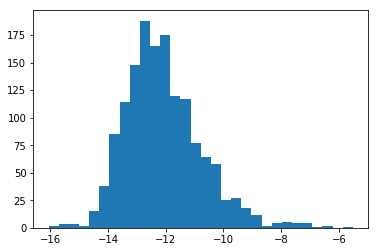

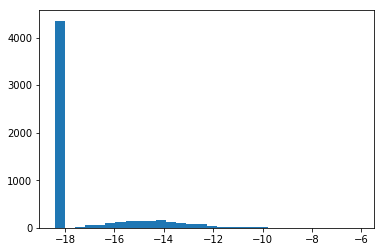

In [254]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
## plot frequency distribution
NE_freq_grouped = combined_freq_anchor_data.groupby(['data_name_fixed', 'NE_fixed']).apply(lambda x: x.drop_duplicates('date_day').loc[:, 'freq'].mean())
print('%d unique NEs'%(NE_freq_grouped.shape[0]))
NE_freq_grouped = np.log(NE_freq_grouped[NE_freq_grouped > 0.])
## nonzero log
plt.hist(NE_freq_grouped, bins=30)
plt.show()
## all log
NE_log_freq_grouped = combined_freq_anchor_data.groupby(['data_name_fixed', 'NE_fixed']).apply(lambda x: x.drop_duplicates('date_day').loc[:, 'freq_log'].mean())
plt.hist(NE_log_freq_grouped, bins=30)
plt.show()

This is a very skewed distribution! But maybe when we run prediction on the most frequent NEs then things will even out.

### Predict anchor at time=t ~ frequency at time=t-1

In [265]:
import pandas as pd
import dateutil
from datetime import datetime
from data_helpers import extract_freq_NEs
import numpy as np

## add relevant dates
# relevant hurricane dates
event_dates = pd.read_csv('../../data/hurricane_data/hurricane_dates.tsv', sep='\t', index_col=False, converters={'hurricane_date':lambda x: datetime.strptime('%s EST'%(x), '%d-%m-%y %Z')})
event_dates.rename(columns={'hurricane_name':'data_name_fixed'}, inplace=True)

def assign_time_period(data, event_time_vars):
    time_period = event_time_vars[0]
    for etv in event_time_vars:
        etv_since = 'since_%s'%(etv)
        if(data.loc[etv_since] == 0.):
            break
        time_period = etv
    return time_period

event_dates_pivot = event_dates.pivot(index='data_name_fixed', columns='hurricane_type', values='hurricane_date').reset_index()
combined_freq_anchor_time = pd.merge(combined_freq_anchor_data, event_dates_pivot, on='data_name_fixed')
time_var = 'date_stamp'
combined_freq_anchor_time = combined_freq_anchor_time.assign(**{time_var : combined_freq_anchor_time.loc[:, 'date'].apply(lambda x: x.timestamp())})
# remove all tweets sent before formation time
combined_freq_anchor_time = combined_freq_anchor_time[combined_freq_anchor_time.loc[:, 'form'].apply(lambda x: x.timestamp()) <= combined_freq_anchor_time.loc[:, time_var]]
combined_freq_anchor_time_ = []
# time_var = 'date'
event_time_vars = ['form', 'landfall', 'dissipation']
for data_name_i, data_i in combined_freq_anchor_time.groupby('data_name_fixed'):
    date_min_i = data_i.loc[:, time_var].min()
    for j, x in enumerate(event_time_vars):
        x_since = 'since_%s'%(x)
        data_i.loc[:, x_since] = (data_i.loc[:, time_var] - data_i.loc[:, x].apply(lambda x: x.timestamp())).apply(lambda x: max(0, x))
        # convert to days for better interpretability
        data_i.loc[:, x_since] = data_i.loc[:, x_since] / (3600*24)
    # also get time period variable for completeness
    # ex. formation_period => tweet posted DURING formation period
    data_i = data_i.assign(**{'time_period_type' : data_i.apply(lambda x: assign_time_period(x, event_time_vars), axis=1)})
    combined_freq_anchor_time_.append(data_i)
combined_freq_anchor_time = pd.concat(combined_freq_anchor_time_, axis=0)

## add importance stats

import pickle
geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))

max_pops = pd.Series({k : v.loc[:, 'population'].max() for k,v in geo_dict.items()})
max_names = pd.Series({k : v.loc[:, 'alternate_name_count'].max() for k,v in geo_dict.items()})

combined_freq_anchor_time = combined_freq_anchor_time.assign(max_pop=combined_freq_anchor_time.loc[:, 'NE_fixed'].apply(lambda x : max_pops.loc[x.replace('_', ' ')]))
combined_freq_anchor_time = combined_freq_anchor_time.assign(max_names=combined_freq_anchor_time.loc[:, 'NE_fixed'].apply(lambda x : max_names.loc[x.replace('_', ' ')]))

N_bins = 4
importance_stats = ['max_pop', 'max_names']
combined_tag_data_importance = []
for data_name_i, data_i in combined_freq_anchor_time.groupby('data_name_fixed'):
    data_i_dedup = data_i.drop_duplicates('NE_fixed')
    for importance_stat in importance_stats:
        importance_stat_vals = np.log(data_i_dedup.loc[:, importance_stat]+1.)
        importance_stat_bins = np.linspace(importance_stat_vals.min(), importance_stat_vals.max(), N_bins+1)[1:]
        importance_stat_bin_vals = pd.DataFrame(np.digitize(importance_stat_vals, bins=importance_stat_bins), columns=['%s_bin'%(importance_stat)])
        importance_stat_bin_vals.loc[:, 'NE_fixed'] = data_i_dedup.loc[:, 'NE_fixed'].values
        data_i = pd.merge(data_i, importance_stat_bin_vals, on='NE_fixed')
    combined_tag_data_importance.append(data_i)
combined_tag_data_importance = pd.concat(combined_tag_data_importance, axis=0)

## restrict to freq NEs
## filter to data with frequent entities for better estimation
combined_tag_data_importance_freq_NE = []
dep_var = 'has_descriptor'
top_k_NE_min = 5
for data_name_i, data_i in combined_tag_data_importance.groupby('data_name_fixed'):
    freq_NEs_i = extract_freq_NEs(data_i, dep_var=dep_var, min_count_0=top_k_NE_min, min_count_1=top_k_NE_min)
    data_i_k = data_i[data_i.loc[:, 'NE_fixed'].isin(freq_NEs_i)]
    combined_tag_data_importance_freq_NE.append(data_i_k)
combined_tag_data_importance_freq_NE = pd.concat(combined_tag_data_importance_freq_NE, axis=0)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [267]:
print(combined_tag_data_importance_freq_NE.columns)
display(combined_tag_data_importance_freq_NE.head())

Index(['id', 'txt', 'data_name_fixed', 'username', 'date', 'lang', 'NE',
       'NE_type', 'NE_LOC', 'valid_loc', 'NE_fixed', 'has_descriptor',
       'NE_fixed_clean', 'max_population', 'max_alternate_name_count',
       'max_population_anchor', 'max_population_diff',
       'max_alternate_name_count_anchor', 'max_alternate_name_count_diff',
       'date_day', 'TIME', 'freq', 'freq_log', 'dissipation', 'form',
       'landfall', 'date_stamp', 'since_form', 'since_landfall',
       'since_dissipation', 'time_period_type', 'max_pop', 'max_names',
       'max_pop_bin', 'max_names_bin'],
      dtype='object')


,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,...,landfall,date_stamp,since_form,since_landfall,since_dissipation,time_period_type,max_pop,max_names,max_pop_bin,max_names_bin
0,1036539345782669312,Tropical Storm #Florence is 2790 miles ESE of ...,florence,wralweather,2018-09-03 09:00:12+00:00,en,Raleigh,LOCATION,True,True,...,2018-09-14,1.535965e+09,3.375139,0.0,0.0,form,451066.0,43.0,3,3
1,1039207250282274816,RT @EdValleeWx: Population density map overlai...,florence,kathycalm,2018-09-10 17:41:30+00:00,en,Raleigh,LOCATION,True,True,...,2018-09-14,1.536601e+09,10.737153,0.0,0.0,form,451066.0,43.0,3,3
2,1039317635962351617,RT WarmTV: TV tonight: Take a break from #Hurr...,florence,Seekandfind,2018-09-11 01:00:08+00:00,en,Raleigh,LOCATION,True,True,...,2018-09-14,1.536628e+09,11.041759,0.0,0.0,form,451066.0,43.0,3,3
3,1039358509484269568,RT @johnpavlovitz: I swear zombies are coming....,florence,Charlen06047760,2018-09-11 03:42:33+00:00,en,Raleigh,LOCATION,True,True,...,2018-09-14,1.536637e+09,11.154549,0.0,0.0,form,451066.0,43.0,3,3
4,1039530220099919872,RT @AnthonyFarnell: Not the best start here in...,florence,wnywxguy,2018-09-11 15:04:52+00:00,en,Raleigh,LOCATION,True,True,...,2018-09-14,1.536678e+09,11.628380,0.0,0.0,form,451066.0,43.0,3,3


In [271]:
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_data_pred = combined_tag_data_importance_freq_NE.copy()
scalar_vars = ['since_form', 'since_landfall', 'since_dissipation', 'freq', 'freq_log', 'max_names_bin', 'max_pop_bin']
for x in scalar_vars:
    combined_data_pred = combined_data_pred.assign(**{x : scaler.fit_transform(combined_data_pred.loc[:, x].values.reshape(-1,1))})

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
%%capture joint_data_output
import re
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import fit_evaluate_lr_model
joint_data_results = []
joint_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'freq_log'])
ind_var_sets = [
    ['C(data_name_fixed)', 'freq_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'freq_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'freq_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation', 'freq_log'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation', 'freq_log'],
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else:
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_data_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    joint_data_results.append([data_name, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        joint_data_coeffs.append([[data_name, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
joint_data_results = pd.DataFrame(joint_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
joint_data_coeffs = pd.DataFrame(np.vstack(joint_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [300]:
from models.model_helpers import pandas_df_to_markdown_table
def print_results_coeffs(results, coeffs):
    ## get mean/deviance
    float_cols = ['acc_mean', 'deviance']
    print('printing stats for %s'%(','.join(float_cols)))
    # format cols
    for x in float_cols:
        if(type(results.loc[:, x].iloc[0]) is not str):
            results.loc[:, x] = results.loc[:, x].apply(lambda x: '%.3f'%(x))
    pandas_df_to_markdown_table(results)
    ## get coefficients, p-vals for time and importance vars
    coeff_float_cols = ['coeff', 'p_val']
    print('printing stats for %s'%(','.join(coeff_float_cols)))
    # format cols
    for x in coeff_float_cols:
    #     if(type(joint_data_coeffs.loc[:, x].iloc[0]) is not str):
        coeffs.loc[:, x] = coeffs.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
    pandas_df_to_markdown_table(coeffs)

In [275]:
from models.model_helpers import pandas_df_to_markdown_table
## get mean/deviance
float_cols = ['acc_mean', 'deviance']
print('printing stats for %s'%(','.join(float_cols)))
# format cols
for x in float_cols:
    if(type(joint_data_results.loc[:, x].iloc[0]) is not str):
        joint_data_results.loc[:, x] = joint_data_results.loc[:, x].apply(lambda x: '%.3f'%(x))
pandas_df_to_markdown_table(joint_data_results)
## get coefficients, p-vals for time and importance vars
coeff_float_cols = ['coeff', 'p_val']
print('printing stats for %s'%(','.join(coeff_float_cols)))
# format cols
for x in coeff_float_cols:
#     if(type(joint_data_coeffs.loc[:, x].iloc[0]) is not str):
    joint_data_coeffs.loc[:, x] = joint_data_coeffs.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
pandas_df_to_markdown_table(joint_data_coeffs)

printing stats for acc_mean,deviance
data_name|ind_vars|acc_mean|deviance
---|---|---|---
joint|freq_log|0.624|128590.672
joint|C(NE_fixed)+freq_log|0.687|118908.001
joint|C(NE_fixed)+since_form+freq_log|0.686|118814.597
joint|C(NE_fixed)+since_form+since_landfall+since_dissipation+freq_log|0.687|118777.467
joint|max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+freq_log|0.634|127284.712

printing stats for coeff,p_val
data_name|ind_vars|var_name|coeff|p_val
---|---|---|---|---
joint|freq_log|freq_log|-0.432|0.000
joint|C(NE_fixed)+freq_log|freq_log|-0.099|0.000
joint|C(NE_fixed)+since_form+freq_log|since_form|-0.088|0.000
joint|C(NE_fixed)+since_form+freq_log|freq_log|-0.083|0.000
joint|C(NE_fixed)+since_form+since_landfall+since_dissipation+freq_log|since_form|0.003|0.936
joint|C(NE_fixed)+since_form+since_landfall+since_dissipation+freq_log|since_landfall|-0.138|0.000
joint|C(NE_fixed)+since_form+since_landfall+since_dissipation+freq_log|since_dissipation|0.063|0

### Add audience size
Let's add audience size so that we get the full model:

Anchor ~ global importance + temporal importance + audience

TODO: compare with base models because this data is different!!

In [279]:
import pandas as pd
user_data = pd.read_csv('../../data/mined_tweets/user_data/user_data.gz', sep='\t', index_col=False, compression='gzip', usecols=['screen_name', 'followers_count', 'friends_count'])
user_data.rename(columns={'screen_name':'username'}, inplace=True)

In [283]:
## get RT users
import re
RT_MATCHER = re.compile('(?<=RT @)[A-Za-z0-9_]+(?=:)')
# print(RT_MATCHER.search('RT @AnderCoop: blah blah'))
combined_tag_data_importance_freq_NE = combined_tag_data_importance_freq_NE.assign(**{'username_rt' : combined_tag_data_importance_freq_NE.loc[:, 'txt'].apply(lambda x: RT_MATCHER.search(x).group(0) if RT_MATCHER.search(x) is not None else '')})

In [286]:
print(combined_tag_data_importance_freq_NE[combined_tag_data_importance_freq_NE.loc[:, 'username_rt']!=''].loc[:, 'username_rt'].value_counts())
print(combined_tag_data_importance_freq_NE[combined_tag_data_importance_freq_NE.loc[:, 'username_rt']!=''].shape[0])

ABC                232
FoxNews             83
CNN                 71
weatherchannel      59
NBCNightlyNews      49
GMA                 42
ReedTimmerAccu      39
hurrtrackerapp      35
RyanMaue            34
ABCPolitics         32
joshdcaplan         30
cnni                25
cnnbrk              24
BreakingNNow        22
CBSThisMorning      22
WeatherNation       20
Breaking911         20
USATODAY            19
abc13houston        19
ABCWorldNews        18
statesman           16
TODAYshow           16
StormchaserUKEU     15
EricHolthaus        15
capitalweather      15
TexasTribune        14
mikeseidel          14
AlBoeNEWS           13
Bey_Legion          13
ericfisher          13
                  ... 
WilmingtonPD         1
writeEILEEN          1
briskwalk            1
NWSGSP               1
SimonOstler          1
BillCassidy          1
UpbringOrg           1
carolrosenberg       1
KRGVSports           1
FRCdc                1
negroasabache        1
insurancecrime       1
BenMurphyTV

In [296]:
## how much of the original data is covered?
combined_tag_data_users = set(combined_tag_data_importance_freq_NE.loc[:, 'username'].unique())
combined_tag_data_users_rt = set(combined_tag_data_importance_freq_NE.loc[:, 'username_rt'][combined_tag_data_importance_freq_NE.loc[:, 'username_rt'] != ''].unique())
combined_tag_data_users = combined_tag_data_users | combined_tag_data_users_rt
all_users_collected = user_data.loc[:, 'username'].unique()
combined_tag_data_users_with_stats = combined_tag_data_users & set(all_users_collected)
print('%d/%d users covered'%(len(combined_tag_data_users_with_stats), len(combined_tag_data_users)))
# restrict to the covered users
combined_tag_user_data = combined_tag_data_importance_freq_NE[(combined_tag_data_importance_freq_NE.loc[:, 'username'].isin(all_users_collected)) | 
                                                              (combined_tag_data_importance_freq_NE.loc[:, 'username_rt'].isin(all_users_collected))]
print('%d/%d user data'%(combined_tag_user_data.shape[0], combined_tag_data_importance_freq_NE.shape[0]))

23308/86351 users covered
39696/123177 user data


In [297]:
## match follower count to original user
combined_tag_user_data = combined_tag_user_data.assign(**{'username_original' : combined_tag_user_data.apply(lambda x: x.loc['username_rt'] if x.loc['username_rt'] != '' else x.loc['username'], axis=1)})
user_data_relevant = user_data[user_data.loc[:, 'username'].isin(combined_tag_user_data.loc[:, 'username_original'])].drop_duplicates('username', inplace=False).loc[:, ['username', 'followers_count', 'friends_count']]
user_data_relevant.rename(columns={'username':'username_original'}, inplace=True)
combined_tag_user_data = pd.merge(combined_tag_user_data, user_data_relevant, on='username_original', how='inner')
## log-scale
combined_tag_user_data = combined_tag_user_data.assign(**{
    'followers_log' : np.log(combined_tag_user_data.loc[:, 'followers_count'].values + 1.),
    'friends_log' : np.log(combined_tag_user_data.loc[:, 'friends_count'].values + 1.),
})
## add ratio
combined_tag_user_data = combined_tag_user_data.assign(**{
    'followers_friends' : combined_tag_user_data.loc[:, 'followers_log'].values - combined_tag_user_data.loc[:, 'friends_log'].values,
})

Now let's try the same thing as before.

In [298]:
%%capture joint_data_output
import re
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import fit_evaluate_lr_model
joint_data_results = []
joint_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'freq_log', 'followers_log', 'followers_friends'])
ind_var_sets = [
    ['C(data_name_fixed)', 'C(NE_fixed)', 'freq_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'freq_log', 'followers_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'freq_log', 'followers_friends'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'followers_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'followers_friends'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation', 'followers_log'],
    ['C(data_name_fixed)', 'C(NE_fixed)', 'since_form', 'since_landfall', 'since_dissipation', 'followers_friends'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation', 'followers_log'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation', 'followers_friends'],
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_tag_user_data, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    joint_data_results.append([data_name, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        joint_data_coeffs.append([[data_name, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
joint_data_results = pd.DataFrame(joint_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
joint_data_coeffs = pd.DataFrame(np.vstack(joint_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [299]:
joint_data_output.show()

testing ind_vars = C(data_name_fixed),C(NE_fixed),freq_log
formula: max_population_anchor ~ C(data_name_fixed) + C(NE_fixed) + freq_log
                                        Generalized Linear Model Regression Results                                        
Dep. Variable:     ['max_population_anchor[False]', 'max_population_anchor[True]']   No. Observations:                39593
Model:                                                                         GLM   Df Residuals:                    39253
Model Family:                                                             Binomial   Df Model:                          339
Link Function:                                                               logit   Scale:                          1.0000
Method:                                                                       IRLS   Log-Likelihood:                -20551.
Date:                                                             Fri, 03 May 2019   Deviance:                       411

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [301]:
print_results_coeffs(joint_data_results, joint_data_coeffs)

printing stats for acc_mean,deviance
data_name|ind_vars|acc_mean|deviance
---|---|---|---
joint|C(data_name_fixed)+C(NE_fixed)+freq_log|0.660|41101.769
joint|C(data_name_fixed)+C(NE_fixed)+freq_log+followers_log|0.658|41020.994
joint|C(data_name_fixed)+C(NE_fixed)+freq_log+followers_friends|0.660|41016.921
joint|C(data_name_fixed)+C(NE_fixed)+since_form|0.660|41057.545
joint|C(data_name_fixed)+C(NE_fixed)+since_form+followers_log|0.660|40981.860
joint|C(data_name_fixed)+C(NE_fixed)+since_form+followers_friends|0.654|40977.997
joint|C(data_name_fixed)+C(NE_fixed)+since_form+since_landfall+since_dissipation|0.646|40999.406
joint|C(data_name_fixed)+C(NE_fixed)+since_form+since_landfall+since_dissipation+followers_log|0.661|40925.758
joint|C(data_name_fixed)+C(NE_fixed)+since_form+since_landfall+since_dissipation+followers_friends|0.645|40924.096
joint|C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.609|43939.989
joint|C(data_name_fixed)+max_pop_b

OK great. So adding audience stats didn't significantly help prediction or deviance, but the audience stats have consistently positive correlations.

Same thing but without `NE_fixed`.

In [302]:
%%capture joint_data_output
import re
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import fit_evaluate_lr_model
joint_data_results = []
joint_data_coeffs = []
coeff_names_to_track = set(['since_form', 'since_landfall', 'since_dissipation', 'freq_log', 'followers_log', 'followers_friends'])
ind_var_sets = [
    ['C(data_name_fixed)', 'freq_log'],
    ['C(data_name_fixed)', 'freq_log', 'followers_log'],
    ['C(data_name_fixed)', 'freq_log', 'followers_friends'],
    ['C(data_name_fixed)', 'since_form'],
    ['C(data_name_fixed)', 'since_form', 'followers_log'],
    ['C(data_name_fixed)', 'since_form', 'followers_friends'],
    ['C(data_name_fixed)', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'since_form', 'since_landfall', 'since_dissipation', 'followers_log'],
    ['C(data_name_fixed)', 'since_form', 'since_landfall', 'since_dissipation', 'followers_friends'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation', 'followers_log'],
    ['C(data_name_fixed)', 'max_pop_bin', 'max_names_bin', 'since_form', 'since_landfall', 'since_dissipation', 'followers_friends'],
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_tag_user_data, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    joint_data_results.append([data_name, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        joint_data_coeffs.append([[data_name, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
joint_data_results = pd.DataFrame(joint_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
joint_data_coeffs = pd.DataFrame(np.vstack(joint_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [303]:
print_results_coeffs(joint_data_results, joint_data_coeffs)

printing stats for acc_mean,deviance
data_name|ind_vars|acc_mean|deviance
---|---|---|---
joint|C(data_name_fixed)+freq_log|0.592|44180.963
joint|C(data_name_fixed)+freq_log+followers_log|0.606|44079.467
joint|C(data_name_fixed)+freq_log+followers_friends|0.604|44076.097
joint|C(data_name_fixed)+since_form|0.591|44423.046
joint|C(data_name_fixed)+since_form+followers_log|0.594|44340.043
joint|C(data_name_fixed)+since_form+followers_friends|0.595|44333.434
joint|C(data_name_fixed)+since_form+since_landfall+since_dissipation|0.590|44327.140
joint|C(data_name_fixed)+since_form+since_landfall+since_dissipation+followers_log|0.595|44247.211
joint|C(data_name_fixed)+since_form+since_landfall+since_dissipation+followers_friends|0.596|44244.530
joint|C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation|0.609|43939.989
joint|C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+followers_log|0.614|43858.311
joint|C(data_name

Slightly better results here! The audience variables provide slight predictive power and still have significant positive correlation with anchor probability.

### Interrupted time series
What if we include both (1) the binary time period variables (intercept) and (2) the time period slope variables? This would be like having an interrupted time series model, using the sub-events as interruptions.

$$\text{Anchor} \sim \sum_{i} (is\_during\_i + days\_since\_i) + \epsilon$$

TODO: would we need a separate intercept and slope for each NE? That seems like overfitting.

In [18]:
## get full combined data
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import models.predict_descriptor_in_twitter
reload(models.predict_descriptor_in_twitter)
from models.predict_descriptor_in_twitter import load_clean_data
N_time_bins = 5
top_k_NE_min = 5
combined_data = load_clean_data('../../data/mined_tweets/combined_tweet_tag_data_NE_flat.gz', dep_var='max_population_anchor', N_time_bins=N_time_bins, NE_col='NE_fixed', top_k_NE_min=top_k_NE_min)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [2]:
## we have to change the time vars so that they are only active during their respective time periods
## e.g. if event_type==landfall, since_landfall > 0. else 0.
event_names = ['form', 'landfall', 'dissipation']
for event_name in event_names:
    event_name_since = 'since_%s'%(event_name)
    combined_data = combined_data.assign(**{'%s_strict'%(event_name_since) : combined_data.loc[:, event_name_since] * (combined_data.loc[:, 'time_period_type']==event_name).astype(int)})

In [377]:
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_data_pred = combined_data.copy()
scalar_vars = ['since_%s_strict'%(event_name) for event_name in event_names]
for x in scalar_vars:
    combined_data_pred = combined_data_pred.assign(**{x : scaler.fit_transform(combined_data_pred.loc[:, x].values.reshape(-1,1))})
## add NULL var
combined_data_pred = combined_data_pred.assign(**{'NULL':1})

In [378]:
## add binary time variables
event_names = ['form', 'landfall', 'dissipation']
time_var = 'time_event_type'
for event_name in event_names:
    event_name_since = 'since_%s'%(event_name)
    combined_data_pred = combined_data_pred.assign(**{'%s_binary'%(event_name) : (combined_data_pred.loc[:, event_name_since] > 0.).astype(int)})

In [379]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
coeff_names_to_track = set(event_names_binary + event_names_since)
ind_var_sets = [
    ['NULL'],
    ['C(data_name_fixed)',] + event_names_since + event_names_binary,
    ['C(NE_fixed)', 'C(data_name_fixed)'] + event_names_since + event_names_binary,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)']  + event_names_since + event_names_binary,
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_data_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [380]:
print_results_coeffs(its_data_results, its_data_coeffs)

printing stats for acc_mean,deviance
ind_vars|acc_mean|deviance
---|---|---
NULL|0.609|155120.979
C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.617|151555.811
C(NE_fixed)+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.679|138935.006
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.622|150061.615

printing stats for coeff,p_val
ind_vars|var_name|coeff|p_val
---|---|---|---
C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_form|0.092|0.000
C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_landfall|-0.166|0.000
C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_dissipation|0.057|

- Weak/negative `form_binary`, insignificant/positive `landfall_binary`, positive `dissipation_binary`.
- Positive `since_form`, negative `since_landfall`, positive `since_dissipation`.

Pretty clear sign of "forgetting" hypothesis.

TODO: Same thing but for separate data sets.

In [344]:
%%capture per_data_time_output
from models.model_helpers import fit_evaluate_lr_model
its_per_data_results = []
its_per_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
coeff_names_to_track = set(event_names_binary + event_names_since)
ind_var_sets = [
    ['C(data_name_fixed)',] + event_names_since + event_names_binary,
    ['C(NE_fixed)', 'C(data_name_fixed)'] + event_names_since + event_names_binary,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)']  + event_names_since + event_names_binary,
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
group_var = 'data_name_fixed'
for data_name_i, data_i in combined_data_pred.groupby(group_var):
    for ind_var_set in ind_var_sets:
        print('testing ind_vars = %s'%(','.join(ind_var_set)))
        model_results, predict_acc = fit_evaluate_lr_model(data_i, ind_var_set, dep_var, test=test_pct, balance=True)
        print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
        its_per_data_results.append([data_name_i, '+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
        if(len(coeff_names_to_track & set(ind_var_set)) > 0):
            its_per_data_coeffs.append([[data_name_i, '+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_per_data_results = pd.DataFrame(its_per_data_results, columns=['data_name', 'ind_vars', 'acc_mean', 'deviance'])
its_per_data_coeffs = pd.DataFrame(np.vstack(its_per_data_coeffs), columns=['data_name', 'ind_vars', 'var_name', 'coeff', 'p_val'])

In [345]:
for data_name_i in its_per_data_results.loc[:, 'data_name'].unique():
    res_i = its_per_data_results[its_per_data_results.loc[:, 'data_name']==data_name_i]
    coeffs_i = its_per_data_coeffs[its_per_data_coeffs.loc[:, 'data_name']==data_name_i]
    print('**%s results**'%(data_name_i))
    print_results_coeffs(res_i, coeffs_i)

**florence results**
printing stats for acc_mean,deviance
data_name|ind_vars|acc_mean|deviance
---|---|---|---
florence|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.517|8945.554
florence|C(NE_fixed)+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.571|8485.725
florence|max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.544|8903.359

printing stats for coeff,p_val
data_name|ind_vars|var_name|coeff|p_val
---|---|---|---|---
florence|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_form|0.506|0.000
florence|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_landfall|-0.512|0.000
florence|C(data_name_fixed)+since_form+since_landfall+since_dissipat

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


data_name|ind_vars|var_name|coeff|p_val
---|---|---|---|---
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_form|0.061|0.149
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_landfall|-0.189|0.000
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_dissipation|0.114|0.000
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|form_binary|-0.814|0.000
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|landfall_binary|0.085|0.044
harvey|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|dissipation_binary|0.374|0.000
harvey|C(NE_fixed)+C(data_name_fixed)+since_form+since_landfall+since_dis

data_name|ind_vars|var_name|coeff|p_val
---|---|---|---|---
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_form|0.169|0.525
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_landfall|-0.194|0.467
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|since_dissipation|0.033|0.297
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|form_binary|-0.435|0.180
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|landfall_binary|0.070|0.755
michael|C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|dissipation_binary|0.019|0.861
michael|C(NE_fixed)+C(data_name_fixed)+since_form+since_landfall+si

data_name|since_form_intercept|since_landfall_intercept|since_dissipation_intercept
---|---|---|---
florence|0.|0.|0.
harvey|0.|0.|0.
irma|0.|0.|0.
maria|0.|0.|0.
michael|0.|0.|0.

data_name|since_form|since_landfall|since_dissipation
---|---|---|---
florence|0.|0.|0.
harvey|0.|0.|0.
irma|0.|0.|0.
maria|0.|0.|0.
michael|0.|0.|0.

Same thing with (1) followers and (2) frequency.

In [352]:
import pandas as pd
import re
def add_user_data(data, user_data_file='../../data/mined_tweets/user_data/user_data.gz'):
    user_data = pd.read_csv(user_data_file, sep='\t', index_col=False, compression='gzip', usecols=['screen_name', 'followers_count', 'friends_count'])
    user_data.rename(columns={'screen_name':'username'}, inplace=True)
    ## get RT users
    RT_MATCHER = re.compile('(?<=RT @)[A-Za-z0-9_]+(?=:)')
    # print(RT_MATCHER.search('RT @AnderCoop: blah blah'))
    data = data.assign(**{'username_rt' : data.loc[:, 'txt'].apply(lambda x: RT_MATCHER.search(x).group(0) if RT_MATCHER.search(x) is not None else '')})
    ## how much of the original data is covered?
    data_users = set(data.loc[:, 'username'].unique())
    data_users_rt = set(data.loc[:, 'username_rt'][data.loc[:, 'username_rt'] != ''].unique())
    data_users = data_users | data_users_rt
    all_users_collected = user_data.loc[:, 'username'].unique()
    data_users_with_stats = data_users & set(all_users_collected)
    print('%d/%d users covered'%(len(data_users_with_stats), len(data_users)))
    # restrict to the covered users
    data_user_combined = data[(data.loc[:, 'username'].isin(all_users_collected)) | 
                             (data.loc[:, 'username_rt'].isin(all_users_collected))]
    print('%d/%d user data'%(data_user_combined.shape[0], data.shape[0]))
    ## match follower count to original user
    data_user_combined = data_user_combined.assign(**{'username_original' : data_user_combined.apply(lambda x: x.loc['username_rt'] if x.loc['username_rt'] != '' else x.loc['username'], axis=1)})
    username_original_set = data_user_combined.loc[:, 'username_original'].unique()
    user_data_relevant = user_data[user_data.loc[:, 'username'].isin(username_original_set)].drop_duplicates('username', inplace=False).loc[:, ['username', 'followers_count', 'friends_count']]
    user_data_relevant.rename(columns={'username':'username_original'}, inplace=True)
    data_user_combined = pd.merge(data_user_combined, user_data_relevant, on='username_original', how='inner')
    ## log-scale
    data_user_combined = data_user_combined.assign(**{
        'followers_log' : np.log(data_user_combined.loc[:, 'followers_count'].values + 1.),
        'friends_log' : np.log(data_user_combined.loc[:, 'friends_count'].values + 1.),
    })
    ## add ratio
    data_user_combined = data_user_combined.assign(**{
        'followers_friends' : data_user_combined.loc[:, 'followers_log'].values - data_user_combined.loc[:, 'friends_log'].values,
    })
    return data_user_combined

In [353]:
## add user data
combined_data_user = add_user_data(combined_data)

25861/95930 users covered
45878/140769 user data


In [381]:
## norm-scale
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_data_user_pred = combined_data_user.copy()
event_names = ['form', 'landfall', 'dissipation']
user_stats = ['followers_log', 'followers_friends']
scalar_vars = ['since_%s'%(event_name) for event_name in event_names] + user_stats
for x in scalar_vars:
    combined_data_user_pred = combined_data_user_pred.assign(**{x : scaler.fit_transform(combined_data_user_pred.loc[:, x].values.reshape(-1,1))})
## add NULL var
combined_data_user_pred = combined_data_user_pred.assign(**{'NULL':1})
## add binary time variables
event_names = ['form', 'landfall', 'dissipation']
time_var = 'time_event_type'
for event_name in event_names:
    event_name_since = 'since_%s'%(event_name)
    combined_data_user_pred = combined_data_user_pred.assign(**{'%s_binary'%(event_name) : (combined_data_user_pred.loc[:, event_name_since] > 0.).astype(int)})

In [382]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
user_stats = ['followers_log', 'followers_friends']
coeff_names_to_track = set(event_names_binary + event_names_since + user_stats)
ind_var_sets = [
    ['NULL',],
    user_stats,
    ['C(data_name_fixed)',],
    ['C(data_name_fixed)',] + user_stats,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)',]  + event_names_since + event_names_binary,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)', ] + user_stats + event_names_since + event_names_binary,
#     ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)', 'followers_friends']  + event_names_since + event_names_binary,
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_data_user_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [383]:
print_results_coeffs(its_data_results, its_data_coeffs)

printing stats for acc_mean,deviance
ind_vars|acc_mean|deviance
---|---|---
NULL|0.495|54203.704
followers_log+followers_friends|0.518|54117.758
C(data_name_fixed)|0.590|52406.612
C(data_name_fixed)+followers_log+followers_friends|0.591|52319.085
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.593|52024.382
max_pop_bin+max_names_bin+C(data_name_fixed)+followers_log+followers_friends+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.596|51951.981

printing stats for coeff,p_val
ind_vars|var_name|coeff|p_val
---|---|---|---
followers_log+followers_friends|followers_log|0.013|0.470
followers_log+followers_friends|followers_friends|0.084|0.000
C(data_name_fixed)+followers_log+followers_friends|followers_log|0.033|0.073
C(data_name_fixed)+followers_log+followers_friends|followers_friends|0.071|0.000
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since

Let's run the frequency regression again to make sure we're still on track with earlier results.

In [23]:
import numpy as np
import pandas as pd
import re
from datetime import timedelta
def add_freq_data(data, freq_file_name='../../data/mined_tweets/combined_tweet_tag_data_NE_freq.gz'):
    freq = pd.read_csv(freq_file_name, sep='\t', index_col=False, compression='gzip', converters={'TIME':dateutil.parser.parse})
    ## add time data
    metadata_cols = ['TIME', 'DATA_NAME']
    avoid_cols = ['#hash', '<url>', '<_url', 'url_>', '@user', '–_', '-_', '<num>']
    avoid_matcher = re.compile('|'.join(avoid_cols))
    loc_cols = [x for x in freq.columns if x.endswith('_loc') and avoid_matcher.search(x) is None]
    freq_loc = freq.loc[:, loc_cols + metadata_cols]
    display(freq_loc.head())
    ## melt to yield one row per NE/TIME/DATA cooccurrence
    freq_loc = pd.melt(freq_loc, id_vars=metadata_cols, value_vars=loc_cols, value_name='freq', var_name='NE_fixed')
    # replace LOC marker
    freq_loc = freq_loc.assign(**{'NE_fixed' : freq_loc.loc[:, 'NE_fixed'].apply(lambda x: x.replace('_loc', ''))})
    # add previous time
    time_lag = 1
    freq_loc = freq_loc.assign(**{'TIME_JOIN' : freq_loc.loc[:, 'TIME'].apply(lambda x: x + timedelta(days=time_lag))})
#     display(freq_loc.head())
    ## merge with tag data
    time_var = 'date_day'
    data_name_var = 'data_name_fixed'
    data = data.assign(**{
        'TIME_JOIN' : data.loc[:, time_var],
        'DATA_NAME' : data.loc[:, data_name_var],
    })
    freq_anchor_data = pd.merge(data, freq_loc, on=['TIME_JOIN', 'DATA_NAME', 'NE_fixed'], how='left')
    freq_anchor_data.drop(['TIME_JOIN', 'DATA_NAME'], axis=1, inplace=True)
    freq_anchor_data.fillna(0, inplace=True)
    # log-norm frequency data
    freq_anchor_data = freq_anchor_data.assign(**{'freq_log' : freq_anchor_data.loc[:, 'freq'].apply(lambda x: np.log(x+1e-8))})
    # show data
    display(freq_anchor_data.head())
    print('%d/%d samples'%(freq_anchor_data.shape[0], data.shape[0]))
    return freq_anchor_data

In [24]:
combined_freq_anchor_data = add_freq_data(combined_data)

,__loc,_ars_technica_loc,_dade_loc,_diario_loc,_ee_loc,_excelsior_loc,_la_mancha_loc,_misiones_loc,_noroeste_loc,_telemundo_loc,...,youngstown_loc,yucatan_channel_loc,yucatan_loc,z_digital_loc,zello_canal_loc,zephyrhills_loc,zulia_loc,zurich_loc,TIME,DATA_NAME
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-29,florence
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-30,florence
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-31,florence
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-09-01,florence
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-09-02,florence


,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,...,since_landfall,since_dissipation,time_period_type,max_pop,max_names,max_pop_bin,max_names_bin,TIME,freq,freq_log
0,1036539345782669312,Tropical Storm #Florence is 2790 miles ESE of ...,florence,wralweather,1.535965e+09,en,Raleigh,LOCATION,True,True,...,0.0,0.0,form,451066.0,43.0,4,4,2018-09-02 00:00:00,0.000000,-18.420681
1,1039207250282274816,RT @EdValleeWx: Population density map overlai...,florence,kathycalm,1.536601e+09,en,Raleigh,LOCATION,True,True,...,0.0,0.0,form,451066.0,43.0,4,4,2018-09-09 00:00:00,0.000000,-18.420681
2,1039317635962351617,RT WarmTV: TV tonight: Take a break from #Hurr...,florence,Seekandfind,1.536628e+09,en,Raleigh,LOCATION,True,True,...,0.0,0.0,form,451066.0,43.0,4,4,2018-09-10 00:00:00,0.000062,-9.688275
3,1039358509484269568,RT @johnpavlovitz: I swear zombies are coming....,florence,Charlen06047760,1.536637e+09,en,Raleigh,LOCATION,True,True,...,0.0,0.0,form,451066.0,43.0,4,4,2018-09-10 00:00:00,0.000062,-9.688275
4,1039530220099919872,RT @AnthonyFarnell: Not the best start here in...,florence,wnywxguy,1.536678e+09,en,Raleigh,LOCATION,True,True,...,0.0,0.0,form,451066.0,43.0,4,4,2018-09-10 00:00:00,0.000062,-9.688275


140769/140769 samples


In [26]:
## norm-scale
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_freq_pred = combined_freq_anchor_data.copy()
event_names = ['form', 'landfall', 'dissipation']
freq_stats = ['freq_log']
scalar_vars = ['since_%s'%(event_name) for event_name in event_names] + freq_stats
for x in scalar_vars:
    combined_freq_pred = combined_freq_pred.assign(**{x : scaler.fit_transform(combined_freq_pred.loc[:, x].values.reshape(-1,1))})
## add NULL var
combined_freq_pred = combined_freq_pred.assign(**{'NULL':1})
## add binary time variables
event_names = ['form', 'landfall', 'dissipation']
time_var = 'time_event_type'
for event_name in event_names:
    event_name_since = 'since_%s'%(event_name)
    combined_freq_pred = combined_freq_pred.assign(**{'%s_binary'%(event_name) : (combined_freq_pred.loc[:, event_name_since] > 0.).astype(int)})

In [30]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
freq_stats = ['freq_log']
coeff_names_to_track = set(event_names_binary + event_names_since + freq_stats)
ind_var_sets = [
    ['NULL',],
    freq_stats,
    ['C(data_name_fixed)',] + freq_stats,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)',]  + event_names_since + event_names_binary,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)', ] + freq_stats + event_names_since + event_names_binary,
#     ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)', 'followers_friends']  + event_names_since + event_names_binary,
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_freq_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [32]:
from importlib import reload
import models.model_helpers
reload(models.model_helpers)
from models.model_helpers import print_results_coeffs
print_results_coeffs(its_data_results, its_data_coeffs)

ind_vars|acc_mean|deviance
---|---|---
NULL|0.496|155120.979
freq_log|0.594|150788.209
C(data_name_fixed)+freq_log|0.607|148826.672
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.594|149938.108
max_pop_bin+max_names_bin+C(data_name_fixed)+freq_log+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.621|147418.554

ind_vars|var_name|coeff|p_val
---|---|---|---
freq_log|freq_log|-0.391|0.000
C(data_name_fixed)+freq_log|freq_log|-0.363|0.000
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|max_pop_bin|0.041|0.000
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|max_names_bin|-0.235|0.000
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+l

Same thing but with user data!!

In [35]:
from importlib import reload
import models.predict_descriptor_in_twitter
reload(models.predict_descriptor_in_twitter)
from models.predict_descriptor_in_twitter import add_user_data
combined_freq_user_anchor_data = add_user_data(combined_freq_anchor_data)

25861/95930 users covered
45878/140769 user data


In [37]:
## norm-scale
## rescale predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_freq_user_pred = combined_freq_user_anchor_data.copy()
event_names = ['form', 'landfall', 'dissipation']
freq_stats = ['freq_log']
user_stats = ['followers_log', 'followers_friends']
scalar_vars = ['since_%s'%(event_name) for event_name in event_names] + freq_stats + user_stats
for x in scalar_vars:
    combined_freq_user_pred = combined_freq_user_pred.assign(**{x : scaler.fit_transform(combined_freq_user_pred.loc[:, x].values.reshape(-1,1))})
## add NULL var
combined_freq_user_pred = combined_freq_user_pred.assign(**{'NULL':1})
## add binary time variables
event_names = ['form', 'landfall', 'dissipation']
time_var = 'time_event_type'
for event_name in event_names:
    event_name_since = 'since_%s'%(event_name)
    combined_freq_user_pred = combined_freq_user_pred.assign(**{'%s_binary'%(event_name) : (combined_freq_user_pred.loc[:, event_name_since] > 0.).astype(int)})

In [38]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
freq_stats = ['freq_log']
user_stats = ['followers_log', 'followers_friends']
freq_user_stats = freq_stats + user_stats
coeff_names_to_track = set(event_names_binary + event_names_since + freq_user_stats)
ind_var_sets = [
    ['NULL',],
    freq_user_stats,
    ['C(data_name_fixed)',] + freq_user_stats,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)',]  + event_names_since + event_names_binary,
    ['max_pop_bin', 'max_names_bin', 'C(data_name_fixed)', ] + freq_user_stats + event_names_since + event_names_binary,
]
cat_coeff_names_to_track = []
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_freq_user_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [39]:
print_results_coeffs(its_data_results, its_data_coeffs)

ind_vars|acc_mean|deviance
---|---|---
NULL|0.495|54203.704
freq_log+followers_log+followers_friends|0.553|53506.115
C(data_name_fixed)+freq_log+followers_log+followers_friends|0.596|51950.182
max_pop_bin+max_names_bin+C(data_name_fixed)+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.593|52024.382
max_pop_bin+max_names_bin+C(data_name_fixed)+freq_log+followers_log+followers_friends+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.601|51635.222

ind_vars|var_name|coeff|p_val
---|---|---|---
freq_log+followers_log+followers_friends|freq_log|-0.249|0.000
freq_log+followers_log+followers_friends|followers_log|0.030|0.093
freq_log+followers_log+followers_friends|followers_friends|0.079|0.000
C(data_name_fixed)+freq_log+followers_log+followers_friends|freq_log|-0.202|0.000
C(data_name_fixed)+freq_log+followers_log+followers_friends|followers_log|0.043|0.019
C(data_name_fixed)+freq_log+followers_log+foll

### Nested regression

Same thing but with all final variable sets (`importance`, `audience`, `prior importance`).

In [43]:
print(combined_freq_user_pred.shape[0])

45758


In [69]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
freq_stats = ['freq_log']
user_stats = ['followers_log', 'followers_friends']
importance_stats = ['max_pop_bin', 'max_names_bin',]
data_name_stats = ['C(data_name_fixed)']
freq_user_stats = freq_stats + user_stats
coeff_names_to_track = set(freq_stats + user_stats + importance_stats + event_names_binary + event_names_since + freq_user_stats + ['Intercept'])
ind_var_sets = [
    ['NULL',],
    data_name_stats + importance_stats + event_names_since + event_names_binary,
    data_name_stats + importance_stats + event_names_since + event_names_binary + user_stats,
    data_name_stats + importance_stats + event_names_since + event_names_binary + user_stats + freq_stats,
]
cat_coeff_names_to_track = ['C\(data_name_fixed\)']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_freq_user_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in coeff_names_to_track or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [57]:
from models.model_helpers import pandas_df_to_markdown_table
def print_results_coeffs(results, coeffs):
    ## get mean/deviance
    float_cols = ['acc_mean', 'deviance']
    print('printing stats for %s'%(','.join(float_cols)))
    # format cols
    for x in float_cols:
        if(type(results.loc[:, x].iloc[0]) is not str):
            results.loc[:, x] = results.loc[:, x].apply(lambda x: '%.3f'%(x))
    print(pandas_df_to_markdown_table(results))
    ## get coefficients, p-vals for time and importance vars
    coeff_float_cols = ['coeff', 'p_val']
    print('printing stats for %s'%(','.join(coeff_float_cols)))
    # format cols
    for x in coeff_float_cols:
    #     if(type(joint_data_coeffs.loc[:, x].iloc[0]) is not str):
        coeffs.loc[:, x] = coeffs.loc[:, x].apply(lambda x: '%.3f'%(float(x)))
    # print name above table
    for ind_var_set_i, coeffs_i in coeffs.groupby('ind_vars'):
        print(ind_var_set_i)
        print(pandas_df_to_markdown_table(coeffs_i.drop('ind_vars', axis=1, inplace=False)))

In [70]:
print_results_coeffs(its_data_results, its_data_coeffs)
## print coeffs in combined table
# for ind_var_set_i, coeffs_i in its_data_coeffs.groupby('ind_vars'):
#     print(ind_var_set_i)
#     print(coeffs_i.drop('ind_vars', axis=1, inplace=False).to_latex(index=False))

printing stats for acc_mean,deviance
ind_vars|acc_mean|deviance
---|---|---
NULL|0.495|54203.704
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary|0.593|52024.382
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary+followers_log+followers_friends|0.596|51951.981
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary+followers_log+followers_friends+freq_log|0.601|51635.222

printing stats for coeff,p_val
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form+since_landfall+since_dissipation+form_binary+landfall_binary+dissipation_binary
var_name|coeff|p_val
---|---|---
Intercept|-2.752|0.000
C(data_name_fixed)[T.harvey]|0.873|0.003
C(data_name_fixed)[T.irma]|1.847|0.000
C(data_name_fixed)[T.maria]|2.947|0.000
C(data_name_fixed)[T.michael]|

## Nested segmented regression

Let's try a segmented regression by coding `since_` variables as 0 during irrelevant intervals.

In [74]:
time_period_var = 'time_period_type'
time_periods = combined_freq_user_pred.loc[:, time_period_var].unique()
for t in time_periods:
    combined_freq_user_pred = combined_freq_user_pred.assign(**{'since_%s_strict'%(t) : combined_freq_user_pred.loc[:, 'since_%s'%(t)] * (combined_freq_user_pred.loc[:, time_period_var]==t).astype(int) })
#     combined_freq_user_pred = combined_freq_user_pred.assign(**{'since_%s_strict'%(t) : combined_freq_user_pred.apply(lambda x: x.loc['since_%s'%(t)] if x.loc[time_period_var]==t else 0., axis=1)})
#     combined_freq_user_pred = # multiply since_x * time_period == x

In [75]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s_strict'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
freq_stats = ['freq_log']
user_stats = ['followers_log', 'followers_friends']
importance_stats = ['max_pop_bin', 'max_names_bin',]
data_name_stats = ['C(data_name_fixed)']
freq_user_stats = freq_stats + user_stats
coeff_names_to_track = set(freq_stats + user_stats + importance_stats + event_names_binary + event_names_since + freq_user_stats + ['Intercept'])
ind_var_sets = [
    ['NULL',],
    data_name_stats + importance_stats + event_names_since + event_names_binary,
    data_name_stats + importance_stats + event_names_since + event_names_binary + user_stats,
    data_name_stats + importance_stats + event_names_since + event_names_binary + user_stats + freq_stats,
]
cat_coeff_names_to_track = ['C\(data_name_fixed\)']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
data_name = 'joint'
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_freq_user_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in coeff_names_to_track or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack`(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])

In [76]:
print_results_coeffs(its_data_results, its_data_coeffs)

printing stats for acc_mean,deviance
ind_vars|acc_mean|deviance
---|---|---
NULL|0.495|54203.704
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form_strict+since_landfall_strict+since_dissipation_strict+form_binary+landfall_binary+dissipation_binary|0.592|52072.905
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form_strict+since_landfall_strict+since_dissipation_strict+form_binary+landfall_binary+dissipation_binary+followers_log+followers_friends|0.595|52001.321
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form_strict+since_landfall_strict+since_dissipation_strict+form_binary+landfall_binary+dissipation_binary+followers_log+followers_friends+freq_log|0.600|51694.186

printing stats for coeff,p_val
C(data_name_fixed)+max_pop_bin+max_names_bin+since_form_strict+since_landfall_strict+since_dissipation_strict+form_binary+landfall_binary+dissipation_binary
var_name|coeff|p_val
---|---|---
Intercept|-0.127|0.016
C(data_name_fixed)[T.harvey]|-1.082|0.000
C(data_name_fixed)[T.irm

### Mixed-effect regression

Let's try the full model with a mixed effect (`data_name_fixed`) to make sure that we're not hallucinating.

In [79]:
from statsmodels.formula.api import mixedlm
group_var = 'data_name_fixed'
dep_var = 'max_population_anchor'
event_names = ['form', 'landfall', 'dissipation']
event_names_since = ['since_%s'%(x) for x in event_names]
event_names_binary = ['%s_binary'%(x) for x in event_names]
freq_stats = ['freq_log']
user_stats = ['followers_log', 'followers_friends']
importance_stats = ['max_pop_bin', 'max_names_bin',]
data_name_stats = ['C(data_name_fixed)']
ind_vars = importance_stats + event_names_since + event_names_binary + user_stats + freq_stats
model = mixedlm('%s ~ %s'%(dep_var, ' + '.join(ind_vars)), data=combined_freq_user_pred, groups=combined_freq_user_pred.loc[:, group_var])
model_results = model.fit()
print(model_results.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: max_population_anchor
No. Observations: 45758   Method:             REML                 
No. Groups:       5       Scale:              0.1901               
Min. group size:  3857    Likelihood:         -27008.6125          
Max. group size:  26156   Converged:          Yes                  
Mean group size:  9151.6                                           
--------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            0.337     0.137    2.460  0.014   0.069   0.606
max_pop_bin          0.002     0.003    0.672  0.501  -0.004   0.009
max_names_bin       -0.019     0.003   -6.732  0.000  -0.024  -0.013
since_form           0.279     0.037    7.546  0.000   0.206   0.351
since_landfall      -0.245     0.030   -8.055  0.000  -0

Similar effects (positive `since_form`, negative `since_landfall`), mostly weak.

### Future problems

TODO: same thing but with fixed effect/slope for each entity? `C(NE_fixed) x since_*_strict`

In [ ]:
%%capture joint_time_output
from models.model_helpers import fit_evaluate_lr_model
its_data_results = []
its_data_coeffs = []
coeff_names_to_track = set(['since_form_strict', 'since_landfall_strict', 'since_dissipation_strict'])
event_vars_strict = ['since_form_strict', 'since_landfall_strict', 'since_dissipation_strict']
ind_var_sets = [
    ['C(NE_fixed)', 'C(NE_fixed) * ' 'C(data_name_fixed)', 'C(time_period_type)', 'since_form_strict', 'since_landfall_strict', 'since_dissipation_strict'],
]
cat_coeff_names_to_track = ['time_period_type']
if(len(cat_coeff_names_to_track) > 0):
    cat_coeff_matcher = re.compile('|'.join(cat_coeff_names_to_track))
else: # otherwise track nothing
    cat_coeff_matcher = re.compile('^$')
dep_var = 'max_population_anchor'
test_pct = 0.9
for ind_var_set in ind_var_sets:
    print('testing ind_vars = %s'%(','.join(ind_var_set)))
    model_results, predict_acc = fit_evaluate_lr_model(combined_data_pred, ind_var_set, dep_var, test=test_pct, balance=True)
    print('data=%s, mean_acc=%.3f, dev=%d'%(data_name_i, np.mean(predict_acc), model_results.deviance))
    its_data_results.append(['+'.join(ind_var_set), np.mean(predict_acc), model_results.deviance])
    if(len(coeff_names_to_track & set(ind_var_set)) > 0):
        its_data_coeffs.append([['+'.join(ind_var_set), i, x, model_results.pvalues.loc[i]] for i, x in zip(model_results.params.index, model_results.params) if i in ind_var_set or cat_coeff_matcher.search(i) is not None])
its_data_results = pd.DataFrame(its_data_results, columns=['ind_vars', 'acc_mean', 'deviance'])
its_data_coeffs = pd.DataFrame(np.vstack(its_data_coeffs), columns=['ind_vars', 'var_name', 'coeff', 'p_val'])